<a href="https://colab.research.google.com/github/amrahmani/Marketing/blob/main/AIMarketing_Ch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Target new customers showing high response likelihood via characteristic analysis for effective direct marketing.**

Number of new customers (enrolled since 2013-12-14): 220

--- K-Means Clustering on New Customers ---


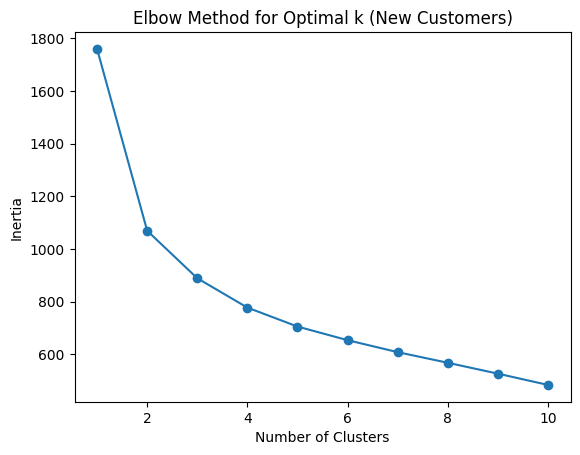


New customers assigned to 3 clusters.
cluster
0    105
2     62
1     53
Name: count, dtype: int64

--- Cluster Analysis ---

Cluster Profiles (Mean Values):
               Income    Recency  Total_Spending  NumWebPurchases  \
cluster                                                             
0        37780.931373  51.342857       77.866667         1.933333   
1        62532.735849  47.169811      554.358491         5.226415   
2        79862.145161  48.806452     1246.306452         4.483871   

         NumStorePurchases  NumWebVisitsMonth   Kidhome  Teenhome  Response  
cluster                                                                      
0                 3.114286           5.838095  0.961905  0.485714  0.038095  
1                 6.509434           4.396226  0.037736  1.056604  0.018868  
2                 7.951613           1.967742  0.112903  0.032258  0.129032  

Average Response Rate per Cluster:
cluster
0    0.038095
1    0.018868
2    0.129032
Name: Response, dty

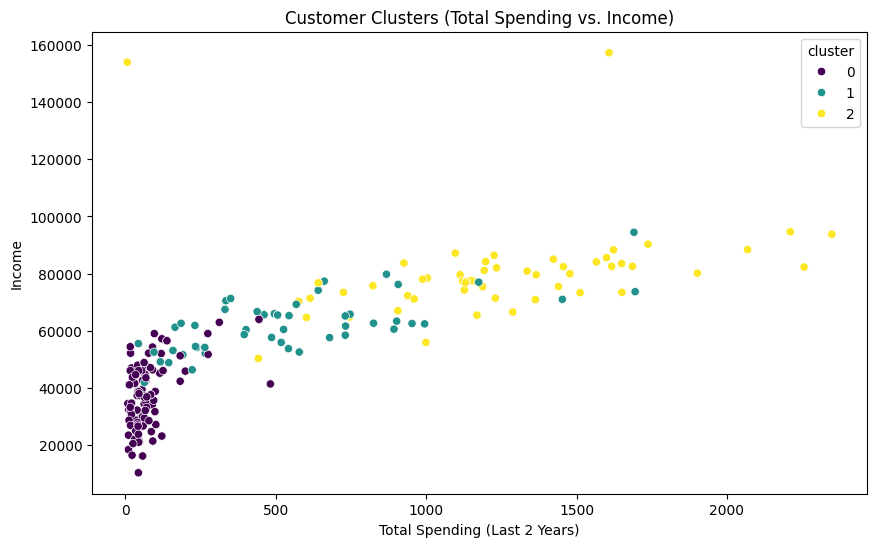


--- Target Segment Selection (Cluster 1) ---
Number of customers in Cluster 1: 53

Characteristics of Target Segment (Mean Values):
Income               62532.735849
Recency                 47.169811
Total_Spending         554.358491
NumWebPurchases          5.226415
NumStorePurchases        6.509434
NumWebVisitsMonth        4.396226
Kidhome                  0.037736
Teenhome                 1.056604
Response                 0.018868
dtype: float64

--- Direct Marketing Campaign Design for the Target Segment ---
Campaign Name: Welcome & Discover Our Premium Selection
Campaign Goal: Acquire new customers from the identified high-potential segment and drive initial purchases.
Target Audience Description: New customers identified in Cluster 1. Based on our analysis, this segment tends to have an average income of $62532.74, a recency of 47.17 days, and a total spending of $554.36. They also show an average of 5.23 web purchases and 6.51 store purchases. Their average response rate to the

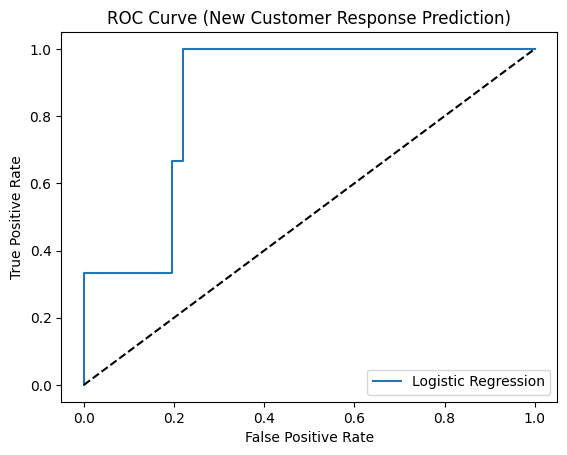

In [5]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/amrahmani/Marketing/main/marketing_campaign_data.csv')

# Convert 'Dt_Customer' to datetime objects
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

# --- Step 1: Define "New Customers" Dynamically ---
# Find the most recent enrollment date
most_recent_enrollment = df['Dt_Customer'].max()

# Calculate the cutoff date for the last 6 months
cutoff_date = most_recent_enrollment - timedelta(days=6 * 30) # Approximately 6 months

# Filter for new customers
new_customers_df = df[df['Dt_Customer'] >= cutoff_date].copy()
print(f"Number of new customers (enrolled since {cutoff_date.strftime('%Y-%m-%d')}): {len(new_customers_df)}")

# --- Step 2: Clustering on New Customers (using K-Means) ---
print("\n--- K-Means Clustering on New Customers ---")

# Feature Engineering for Visualization (Total Spending)
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
new_customers_df['Total_Spending'] = new_customers_df[spending_cols].sum(axis=1)

# Select features for clustering
features_for_clustering = ['Income', 'Recency', 'Total_Spending', 'NumWebPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Kidhome', 'Teenhome']
clustering_data = new_customers_df[features_for_clustering].copy()

# Handle missing values
imputer_cluster = SimpleImputer(strategy='mean')
clustering_data_imputed = pd.DataFrame(imputer_cluster.fit_transform(clustering_data),
                                        columns=clustering_data.columns)

# Scale the data
scaler_cluster = StandardScaler()
scaled_clustering_data = scaler_cluster.fit_transform(clustering_data_imputed)
scaled_clustering_df = pd.DataFrame(scaled_clustering_data, columns=clustering_data.columns)

# Determine the optimal number of clusters (Elbow method)
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(scaled_clustering_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k (New Customers)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply K-Means with a chosen k (let's assume k=3 based on the plot)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
new_customers_df['cluster'] = kmeans.fit_predict(scaled_clustering_data)

print(f"\nNew customers assigned to {n_clusters} clusters.")
print(new_customers_df['cluster'].value_counts())

# --- Cluster Analysis ---
print("\n--- Cluster Analysis ---")
cluster_profiles = new_customers_df.groupby('cluster')[features_for_clustering + ['Response']].mean()
print("\nCluster Profiles (Mean Values):")
print(cluster_profiles)

response_rate_per_cluster = new_customers_df.groupby('cluster')['Response'].mean()
print("\nAverage Response Rate per Cluster:")
print(response_rate_per_cluster)

# --- Cluster Visualization ---
print("\n--- Cluster Visualization ---")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=new_customers_df, x='Total_Spending', y='Income', hue='cluster', palette='viridis')
plt.title('Customer Clusters (Total Spending vs. Income)')
plt.xlabel('Total Spending (Last 2 Years)')
plt.ylabel('Income')
plt.show()

# --- Target Segment Selection ---
target_cluster = 1 # Example: Choosing Cluster 1 as the target segment
target_segment = new_customers_df[new_customers_df['cluster'] == target_cluster]
print(f"\n--- Target Segment Selection (Cluster {target_cluster}) ---")
print(f"Number of customers in Cluster {target_cluster}: {len(target_segment)}")
print("\nCharacteristics of Target Segment (Mean Values):")
print(target_segment[features_for_clustering + ['Response']].mean())

# --- Direct Marketing Campaign Design for the Target Segment ---
print("\n--- Direct Marketing Campaign Design for the Target Segment ---")

campaign_name = "Welcome & Discover Our Premium Selection"
campaign_goal = "Acquire new customers from the identified high-potential segment and drive initial purchases."

# Describe the target audience based on the cluster analysis
target_audience_description = (
    f"New customers identified in Cluster {target_cluster}. Based on our analysis, this segment tends to have "
    f"an average income of ${cluster_profiles.loc[target_cluster, 'Income']:.2f}, a recency of {cluster_profiles.loc[target_cluster, 'Recency']:.2f} days, "
    f"and a total spending of ${cluster_profiles.loc[target_cluster, 'Total_Spending']:.2f}. They also show an average of "
    f"{cluster_profiles.loc[target_cluster, 'NumWebPurchases']:.2f} web purchases and {cluster_profiles.loc[target_cluster, 'NumStorePurchases']:.2f} store purchases. "
    f"Their average response rate to the last campaign was {response_rate_per_cluster.loc[target_cluster]:.2f}."
)
print(f"Campaign Name: {campaign_name}")
print(f"Campaign Goal: {campaign_goal}")
print(f"Target Audience Description: {target_audience_description}")

# Tailor the marketing message
marketing_message = (
    "Welcome to our community! As a valued new customer, discover our premium selection of products tailored to your interests. "
    "Enjoy exclusive introductory offers to help you experience the quality and value we offer."
)
print(f"Marketing Message: {marketing_message}")

# Call to action
call_to_action = "Browse our curated collection and claim your special welcome gift at [Your Website Link] or visit our nearest store."
print(f"Call to Action: {call_to_action}")

# Marketing channels
marketing_channels = ["Email marketing (personalized welcome series)", "Targeted social media ads (based on demographics and interests inferred from the cluster)", "SMS/Text message with a unique offer code"]
print(f"Marketing Channels: {marketing_channels}")

# Offer
offer = "Receive a 15% discount on your first purchase using the code WELCOME15 (online and in-store)."
print(f"Offer: {offer}")

# Measurement metrics
measurement_metrics = ["Number of new customers acquired with the campaign code", "Conversion rate (offer claims / emails/ads/SMS sent)", "Average order value of first purchase", "Customer engagement with welcome emails/ads", "Cost per acquisition (CPA)"]
print(f"Measurement Metrics: {measurement_metrics}")

# AI Optimization Suggestions
ai_optimization_suggestions = [
    "A/B test different welcome offers and messaging to optimize conversion rates.",
    "Personalize product recommendations in welcome emails based on the spending patterns observed in the target cluster.",
    "Utilize optimal send time analysis for email campaigns to maximize open and click-through rates.",
    "Develop lookalike audiences based on the characteristics of the high-responding customers within this target segment for broader acquisition efforts.",
    "Implement dynamic content in emails and website banners to show products most relevant to the identified cluster's preferences."
]
print("\nAI Optimization Suggestions:")
for suggestion in ai_optimization_suggestions:
    print(f"- {suggestion}")

# --- Step 3: Classification Models on New Customers (using Logistic Regression) ---
print("\n--- Logistic Regression for Response Prediction (New Customers) ---")

# Prepare data for classification
X = new_customers_df[['Income', 'Recency', 'Total_Spending', 'NumWebPurchases', 'NumWebVisitsMonth', 'cluster', 'Kidhome', 'Teenhome']]
y = new_customers_df['Response']

# Identify numerical and categorical features
numerical_features_lr = ['Income', 'Recency', 'Total_Spending', 'NumWebPurchases', 'NumWebVisitsMonth', 'Kidhome', 'Teenhome']
categorical_features_lr = ['cluster']

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features_lr),
        ('cat', categorical_transformer, categorical_features_lr)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the Logistic Regression model
logistic_model = Pipeline(steps=[('preprocessor', preprocessor_lr),
                                 ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])

logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)
y_prob = logistic_model.predict_proba(X_test)[:, 1]

# --- Step 4: Analyze the Results ---
print("\n--- Analyzing Logistic Regression Results ---")
# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAUC-ROC Score:", roc_auc_score(y_test, y_prob))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (New Customer Response Prediction)')
plt.legend()
plt.show()

**Activity:**

**Task 1:**
Analyze the purchase channel preferences (NumWebPurchases, NumCatalogPurchases, NumStorePurchases) (e.g., web, catalog, store)  of your highest-responding new customer segment. Based on these insights, recommend the top two direct marketing channels you would prioritize to reach them for a new campaign and justify your choices.

**Task 2:**
Analyze the characteristics of the clusters identified in above. Calculate descriptive statistics (mean, median, standard deviation) for key features within each cluster. Create a "segment profile" for each cluster, summarizing their distinct characteristics (e.g., demographics, spending habits, engagement).

**Task 3:**
Based on the insights gained from the cluster analysis (Task 1) and/or the predictive model, design a targeted direct marketing campaign for one specific customer segment. Consider the segment's characteristics, potential needs, and likelihood to respond.